# IMPORT LIBRARIES

In [9]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


#DATA LOARDER
CIFAR 10

Train datas

Test datas


In [10]:
def data_loader(data_dir, batch_size, random_seed= 81, valid_size=0.1, shuffle=True, test=False):
  # define transforms

  # we define the variable normalize with the mean and standard deviations of
  # each of the channel (red, green, and blue) in the dataset.
  #These can be calculated manually, but are also available online.
  normalize = transforms.Normalize( mean=[0.4914, 0.4822, 0.4465],
                                   std=[0.2023, 0.1994, 0.2010],
                                  )

  transform = transforms.Compose([ transforms.Resize((224,224)),
                                  transforms.ToTensor(),
                                  normalize,
                                ])

  if test:
      dataset = datasets.CIFAR10( root=data_dir, train=False,
                                  download=True, transform=transform,
                                )

      data_loader = torch.utils.data.DataLoader(
                                                dataset,
                                                batch_size=batch_size,
                                                shuffle=shuffle
                                                )

      return data_loader

  # load the dataset
  train_dataset = datasets.CIFAR10(
                                    root=data_dir, train=True,
                                    download=True, transform=transform,
                                  )

  valid_dataset = datasets.CIFAR10(
                                    root=data_dir, train=True,
                                    download=True, transform=transform,
                                  )

  num_train = len(train_dataset)
  # make in index for every element
  indices = [x for x in range(num_train)]

  split = int(np.floor(valid_size * num_train))

  if shuffle:
      np.random.seed( random_seed )
      np.random.shuffle( indices )

  train_idx, valid_idx = indices[split:], indices[:split]
  train_sampler = SubsetRandomSampler(train_idx)
  valid_sampler = SubsetRandomSampler(valid_idx)

  train_loader = torch.utils.data.DataLoader(
      train_dataset, batch_size=batch_size, sampler=train_sampler)

  valid_loader = torch.utils.data.DataLoader(
      valid_dataset, batch_size=batch_size, sampler=valid_sampler)

  return (train_loader, valid_loader)


train_loader, valid_loader = data_loader(data_dir='./data', batch_size=64)

test_loader = data_loader(data_dir='./data', batch_size=64, test=True)

100%|██████████| 170M/170M [00:03<00:00, 46.4MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


# Residual Block
The block that re-use through out the network.

In [11]:
class Residual_Block(nn.Module):
  def __init__(self, in_channel, out_channel, stride = 1, down_sample = None):
    super(Residual_Block, self).__init__()
    self.convolution1 = nn.Sequential(
                                        nn.Conv2d(in_channel, out_channel, kernel_size = 3, stride = stride, padding = 1),
                                        nn.BatchNorm2d(out_channel),
                                        nn.ReLU()
                                      )
    self.convolution2 = nn.Sequential(
                                        nn.Conv2d(out_channel, out_channel, kernel_size = 3, stride = 1, padding = 1 ),
                                        nn.BatchNorm2d(out_channel)
                                      )
    self.down_sample = down_sample
    self.relu = nn.ReLU()
    self.out_channel = out_channel

  def forward(self, x):
    residual = x
    out = self.convolution1(x)
    out = self.convolution2(out)
    if self.down_sample:
      residual = self.down_sample(x)
    out += residual
    out = self.relu(out)
    return(out)


# ResNet34
containing 3, 3, 6, and 3 layers


In [12]:
class ResNet34(nn.Module):
  def __init__(self, block, layers, num_class = 10):
    super(ResNet34, self).__init__()
    self.inplanes= 64
    self.convolution1 = nn.Sequential(
                                        nn.Conv2d(3,64,kernel_size = 7, stride = 2, padding = 3),
                                        nn.BatchNorm2d(64),
                                        nn.ReLU()
                                      )
    self.maxpool = nn.MaxPool2d( kernel_size = 3, stride = 2, padding = 1)
    self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
    self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
    self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
    self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
    self.avgpool = nn.AvgPool2d(7, stride=1)
    self.fc = nn.Linear(512, num_class)

  def _make_layer(self, block, planes, blocks, stride=1):
    down_sample = None
    if stride != 1 or self.inplanes != planes :
      down_sample = nn.Sequential(
                                    nn.Conv2d(self.inplanes, planes, kernel_size = 1, stride = stride),
                                    nn.BatchNorm2d(planes)
                                  )
    layers = []
    layers.append(block(self.inplanes, planes, stride, down_sample))
    self.inplanes = planes
    for i in range(1, blocks):
      layers.append(block(self.inplanes, planes))
    return nn.Sequential(*layers)

  def forward(self, x):
    x = self.convolution1(x)
    x = self.maxpool(x)
    x = self.layer0(x)
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.avgpool(x)
    x = x.view(x.size(0),-1)
    x = self.fc(x)
    return x


# Hyperparameters Settings

In [13]:
num_class = 10
num_epoch = 20
batch_size = 16
learning_rate = 0.01
model = ResNet34(Residual_Block, [3,4,6,3] ).to(device)

# Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD( model.parameters(),
                             lr = learning_rate,
                             weight_decay = 0.001,
                             momentum = 0.9
                            )

# Train The Model
total_step = len(train_loader)

#Training

In [ ]:
import gc
total_step = len(train_loader)

for epoch in range(num_epoch):
  for i, (images, labels) in enumerate(train_loader):
    # tensors => devices
    images = images.to(device)
    labels = labels.to(device)

    # Forward
    outputs = model(images)
    loss = criterion(outputs, labels)

    #Backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # empty cache
    del images, labels, outputs
    torch.cuda.empty_cache()
    gc.collect()

  print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epoch, loss.item() ) )

  #validation
  with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in valid_loader:
      images = images.to(device)
      labels = labels.to(device)
      output = model(images)
      # convert selected index to class number
      _, predicted = torch.max(output.data,1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
      del images, labels, output

    print('Accuracy of the network on the {} validation images: {} %'.format(total, 100 * correct / total))




Epoch [1/20], Loss: 1.1446
Accuracy of the network on the 5000 validation images: 57.8 %
Epoch [2/20], Loss: 0.8710
Accuracy of the network on the 5000 validation images: 70.44 %
Epoch [3/20], Loss: 1.2942
Accuracy of the network on the 5000 validation images: 76.06 %
Epoch [4/20], Loss: 0.5396
Accuracy of the network on the 5000 validation images: 78.76 %
Epoch [5/20], Loss: 1.1416
Accuracy of the network on the 5000 validation images: 78.88 %
Epoch [6/20], Loss: 0.3185
Accuracy of the network on the 5000 validation images: 81.98 %
Epoch [7/20], Loss: 0.6865
Accuracy of the network on the 5000 validation images: 82.78 %
Epoch [8/20], Loss: 0.2066
Accuracy of the network on the 5000 validation images: 82.28 %
Epoch [9/20], Loss: 0.8466
Accuracy of the network on the 5000 validation images: 82.4 %
Epoch [10/20], Loss: 0.2613
Accuracy of the network on the 5000 validation images: 83.48 %
Epoch [11/20], Loss: 0.2555
Accuracy of the network on the 5000 validation images: 83.4 %
Epoch [12/2

# Save

In [ ]:
torch.save(model.state_dict(), "./ss.zip")

# Testing

In [ ]:
with torch.no_grad():
  correct = 0
  total = 0
  for images , labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)

    output = model(images)
    _,predicted = torch.max(output.data,1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    del images, labels, output
  print('Accuracy of the network on the {} validation images: {} %'.format(total, 100 * correct / total))


Accuracy of the network on the 10000 validation images: 83.35 %


torch.Size([64, 3, 224, 224])


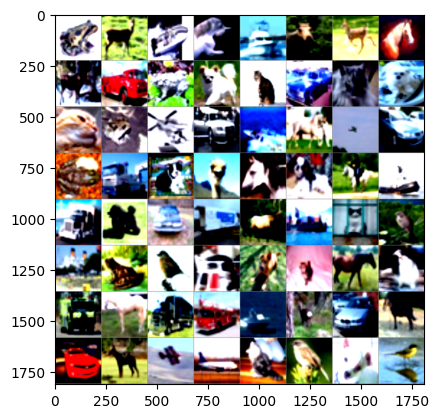

labels   : frog  deer  ship  horse ship  deer  deer  horse deer  truck frog  dog   cat   car   cat   dog   cat   frog  plane car   ship  horse plane car   frog  truck dog   bird  horse dog   horse ship  truck dog   car   truck deer  ship  cat   bird  ship  frog  bird  cat   dog   cat   horse dog   truck horse truck truck ship  deer  car   horse car   dog   plane plane cat   bird  dog   bird 
Predicted:  frog  deer  ship  bird  ship  deer  deer  horse deer  truck frog  dog   cat   car   cat   dog   bird  deer  plane car   plane horse plane car   frog  truck dog   dog   horse dog   horse ship  truck dog   car   truck deer  ship  cat   bird  plane frog  bird  dog   frog  cat   horse bird  truck horse truck truck ship  deer  car   horse car   horse plane plane horse bird  cat   plane


In [45]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(test_loader)
images, labels = next(dataiter)
# test the model
net = ResNet34(Residual_Block, [3,4,6,3] ).to(device)

net.load_state_dict(torch.load("./ss.zip", weights_only=True, map_location=torch.device('cuda')))
outputs = net(images.to(device))
_, predicted = torch.max(outputs, 1)
# show images
imshow(make_grid(images))
# print labels
print('labels   :' , ' '.join(f'{classes[labels[j]]:5s}' for j in range(64)))
print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(64)))


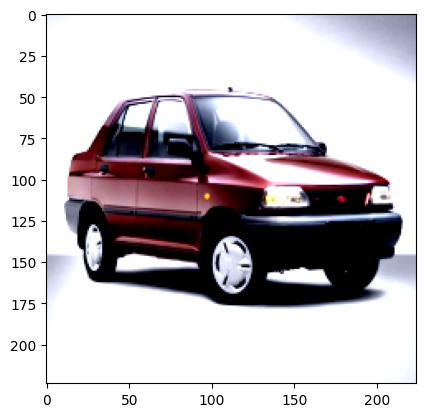

Predicted:  car  


In [52]:
import glob
from torch.utils.data import Dataset
from PIL import Image

class MYTestDataset(Dataset):
    def __init__(self,path):
        normalize = transforms.Normalize( mean=[0.4914, 0.4822, 0.4465],
                                   std=[0.2023, 0.1994, 0.2010],
                                  )

        self.transform = transforms.Compose([ transforms.Resize((224,224)),
                                        transforms.ToTensor(),
                                        normalize,
                                      ])
        self.image_paths = glob.glob(path +'*.jpg')

    def __getitem__(self, index):
        x = Image.open(self.image_paths[index])
        if self.transform is not None:
            x = self.transform(x)
        return x

    def __len__(self):
        return len(self.image_paths)

# get some random training images
test_image = MYTestDataset("./فروش-فوری-پراید-131-min")

dataiter = iter(test_image)
images = next(dataiter)

# test the model
net = ResNet34(Residual_Block, [3,4,6,3] ).to(device)

net.load_state_dict(torch.load("./ss.zip", weights_only=True))
images = images.unsqueeze(0)
outputs = net(images.to(device))
_, predicted = torch.max(outputs, 1)
# show images
imshow(make_grid(images))
# print labels
print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(len(predicted))))
